In [22]:
# Implementing Monte Carlo Simulation to simulate Stock portfolio

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime as dt
from scipy.stats import norm, t
from pandas_datareader import data as pdr
import yfinance as yf

In [7]:
# importing data from Yahoo Finance
def get_data(tickers, start_date, end_date):
    # use yfinance to download stock data
    yf.pdr_override()
    stock_data = pdr.get_data_yahoo(tickers, start_date, end_date)
    stock_data = stock_data['Close']
    returns = stock_data.pct_change()
    mean_returns = returns.mean()
    cov_matrix = returns.cov()
    return returns,mean_returns, cov_matrix

# Portfolio Performance
def portfolioPerformance(weights, meanReturns, covMatrix, Time):
    returns = np.sum(meanReturns*weights)*Time
    std = np.sqrt( np.dot(weights.T, np.dot(covMatrix, weights)) ) * np.sqrt(Time)
    return returns, std

# Make a stock list of indian stocks
stock_list = ['RELIANCE.NS', 'HDFCBANK.NS', 'INFY.NS', 'TCS.NS']

In [18]:
# Define the time period
end_date = dt.datetime.now()
start_date = end_date - dt.timedelta(days=300)

returns, mean_returns, cov_matrix = get_data(stock_list, start_date, end_date)
returns = returns.dropna()

weights = np.random.random(len(stock_list))
weights /= np.sum(weights)
returns['portfolio'] = returns.dot(weights)
# Monte Carlo Simulation
mc_sims = 10000
T  = 100

[*********************100%%**********************]  4 of 4 completed


Text(0.5, 1.0, 'Monte Carlo Simulation of Stock Portfolio with 10000 simulations')

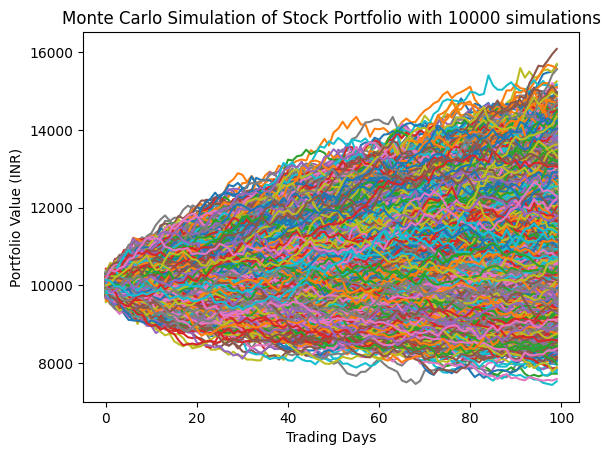

In [10]:
meanM = np.full(shape=(T,len(weights)),fill_value=mean_returns)
meanM = meanM.T

portfolio_sims = np.full(shape=(T,mc_sims),fill_value=0.0)
initial_portfolio_value = 10000
for m in range(0,mc_sims):
    Z = np.random.normal(size=(T,len(weights)))
    L = np.linalg.cholesky(cov_matrix)
    daily_returns = meanM + np.inner(L,Z)
    portfolio_sims[:,m] = np.cumprod(np.inner(weights,daily_returns.T)+1)*initial_portfolio_value

plt.plot(portfolio_sims)
plt.ylabel('Portfolio Value (INR)')
plt.xlabel('Trading Days')
plt.title(f'Monte Carlo Simulation of Stock Portfolio with {mc_sims} simulations')
#plt.show()

In [20]:
def historicalVaR(returns, alpha=5):
    """
    Read in a pandas dataframe of returns / a pandas series of returns
    Output the percentile of the distribution at the given alpha confidence level
    """
    if isinstance(returns, pd.Series):
        return np.percentile(returns, alpha)

    # A passed user-defined-function will be passed a Series for evaluation.
    elif isinstance(returns, pd.DataFrame):
        return returns.aggregate(historicalVaR, alpha=alpha)

    else:
        raise TypeError("Expected returns to be dataframe or series")

def historicalCVaR(returns, alpha=5):
    """
    Read in a pandas dataframe of returns / a pandas series of returns
    Output the CVaR for dataframe / series
    """
    if isinstance(returns, pd.Series):
        belowVaR = returns <= historicalVaR(returns, alpha=alpha)
        return returns[belowVaR].mean()

    # A passed user-defined-function will be passed a Series for evaluation.
    elif isinstance(returns, pd.DataFrame):
        return returns.aggregate(historicalCVaR, alpha=alpha)

    else:
        raise TypeError("Expected returns to be dataframe or series")

# 100 days
Time = 100

hVaR = -historicalVaR(returns['portfolio'], alpha=5)*np.sqrt(Time)
hCVaR = -historicalCVaR(returns['portfolio'], alpha=5)*np.sqrt(Time)
pRet, pStd = portfolioPerformance(weights, mean_returns, cov_matrix, Time)

InitialInvestment = 10000
print('Expected Portfolio Return:      ', round(mc_sims*pRet,2))
print('Value at Risk 95th CI    :      ', round(mc_sims*hVaR,2))
print('Conditional VaR 95th CI  :      ', round(mc_sims*hCVaR,2))

Expected Portfolio Return:       904.0
Value at Risk 95th CI    :       1321.41
Conditional VaR 95th CI  :       1830.27


In [23]:
def var_parametric(portofolioReturns, portfolioStd, distribution='normal', alpha=5, dof=6):
    # because the distribution is symmetric
    if distribution == 'normal':
        VaR = norm.ppf(1-alpha/100)*portfolioStd - portofolioReturns
    elif distribution == 't-distribution':
        nu = dof
        VaR = np.sqrt((nu-2)/nu) * t.ppf(1-alpha/100, nu) * portfolioStd - portofolioReturns
    else:
        raise TypeError("Expected distribution type 'normal'/'t-distribution'")
    return VaR

def cvar_parametric(portofolioReturns, portfolioStd, distribution='normal', alpha=5, dof=6):
    if distribution == 'normal':
        CVaR = (alpha/100)**-1 * norm.pdf(norm.ppf(alpha/100))*portfolioStd - portofolioReturns
    elif distribution == 't-distribution':
        nu = dof
        xanu = t.ppf(alpha/100, nu)
        CVaR = -1/(alpha/100) * (1-nu)**(-1) * (nu-2+xanu**2) * t.pdf(xanu, nu) * portfolioStd - portofolioReturns
    else:
        raise TypeError("Expected distribution type 'normal'/'t-distribution'")
    return CVaR

normVaR = var_parametric(pRet, pStd)
normCVaR = cvar_parametric(pRet, pStd)

tVaR = var_parametric(pRet, pStd, distribution='t-distribution')
tCVaR = cvar_parametric(pRet, pStd, distribution='t-distribution')

print("Normal VaR 95th CI       :      ", round(InitialInvestment*normVaR,2))
print("Normal CVaR 95th CI      :      ", round(InitialInvestment*normCVaR,2))
print("t-dist VaR 95th CI       :      ", round(InitialInvestment*tVaR,2))
print("t-dist CVaR 95th CI      :      ", round(InitialInvestment*tCVaR,2))

Normal VaR 95th CI       :       771.48
Normal CVaR 95th CI      :       1197.12
t-dist VaR 95th CI       :       712.14
t-dist CVaR 95th CI      :       1292.31


In [21]:
def mcVaR(returns, alpha=5):
    """
    Calculate the Monte Carlo VaR of a given portfolio
    """

    if isinstance(returns, pd.Series):
        return  np.percentile(returns, alpha)
    else:
        raise ValueError('Expected a pandas Series')
    
# Shortfall Risk
def mcCVaR(returns, alpha=5):
    """
    Calculate the Monte Carlo VaR of a given portfolio
    """

    if isinstance(returns, pd.Series):
        belowVaR = returns <= mcVaR(returns, alpha=alpha)
        return returns[belowVaR].mean()
    else:
        raise ValueError('Expected a pandas Series')

portResults = pd.Series(portfolio_sims[-1,:])

VaR = initial_portfolio_value - mcVaR(portResults, alpha=5)
CVaR = initial_portfolio_value - mcCVaR(portResults, alpha=5)

print('VaR INR {}'.format(round(VaR,2)))
print('CVaR INR {}'.format(round(CVaR,2)))

VaR INR 683.13
CVaR INR 1073.04


In [25]:
print("\nVaR:")

print(' historical VaR 95th CI   :      ', round(mc_sims*hVaR,2))
print(" Normal VaR 95th CI       :      ", round(mc_sims*normVaR,2))
print(" t-dist VaR 95th CI       :      ", round(mc_sims*tVaR,2))
print(" MC VaR  95th CI          :      ", round(VaR,2))


print("\nCVaR:")

print(' historical CVaR 95th CI  :      ', round(mc_sims*hCVaR,2))
print(" Normal CVaR 95th CI      :      ", round(mc_sims*normCVaR,2))
print(" t-dist CVaR 95th CI      :      ", round(mc_sims*tCVaR,2))
print(" MC CVaR 95th CI          :      ", round(CVaR,2))


VaR:
 historical VaR 95th CI   :       1321.41
 Normal VaR 95th CI       :       771.48
 t-dist VaR 95th CI       :       712.14
 MC VaR  95th CI          :       683.13

CVaR:
 historical CVaR 95th CI  :       1830.27
 Normal CVaR 95th CI      :       1197.12
 t-dist CVaR 95th CI      :       1292.31
 MC CVaR 95th CI          :       1073.04
